# WARNING
**Please make sure to "COPY AND EDIT NOTEBOOK" to use compatible library dependencies! DO NOT CREATE A NEW NOTEBOOK AND COPY+PASTE THE CODE - this will use latest Kaggle dependencies at the time you do that, and the code will need to be modified to make it work. Also make sure internet connectivity is enabled on your notebook**

# *Adrian Pineda Sanchez*

## A00834710


# Preliminaries

Write requirements to file, anytime you run it, in case you have to go back and recover Kaggle dependencies. **MOST OF THESE REQUIREMENTS WOULD NOT BE NECESSARY FOR LOCAL INSTALLATION**

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [1]:
!pip freeze > kaggle_image_requirements.txt

# Download IMDB Movie Review Dataset
Download IMDB dataset

In [2]:
import random
import pandas as pd

## Read-in the reviews and print some basic descriptions of them

!wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar xzf aclImdb_v1.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import urllib.request
import tarfile

# Descargar el archivo aclImdb_v1.tar.gz
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

print("Descargando el archivo...")
urllib.request.urlretrieve(url, filename)

# Extraer el archivo .tar.gz
print("Extrayendo el archivo...")
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()

print("Descarga y extracción completadas.")


Descargando el archivo...
Extrayendo el archivo...
Descarga y extracción completadas.


### Verificar si el dataset se ingreso positivamente y esta balanceado 

In [4]:
import pandas as pd
import os

def leer_resenas(directorio):
    resenas = []
    for clase in ['pos', 'neg']:
        archivos = os.listdir(os.path.join(directorio, clase))
        for nombre_archivo in archivos:
            ruta_archivo = os.path.join(directorio, clase, nombre_archivo)
            with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
                contenido = archivo.read()
                etiqueta = 1 if clase == 'pos' else 0
                resena = dict(texto=contenido, etiqueta=etiqueta)  # Cambié a la función dict
                resenas.append(resena)
    return pd.DataFrame(resenas)

carpeta_base = "aclImdb/train"
datos_resenas = leer_resenas(carpeta_base)

positivas = sum(datos_resenas['etiqueta'] == 1)
negativas = sum(datos_resenas['etiqueta'] == 0)

print(f"Total de reseñas: {len(datos_resenas)}")
print(f"Positivas: {positivas}")
print(f"Negativas: {negativas}")

datos_resenas.head()



Total de reseñas: 25000
Positivas: 12500
Negativas: 12500


texto  etiqueta
0  Bromwell High is a cartoon comedy. It ran at t...         1
1  Homelessness (or Houselessness as George Carli...         1
2  Brilliant over-acting by Lesley Ann Warren. Be...         1
3  This is easily the most underrated film inn th...         1
4  This is not the typical Mel Brooks film. It wa...         1

# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters


In [5]:
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

In [6]:
hiperparametros = [
    {'Nsamp': 1000, 'maxtokens': 50, 'maxtokenlen': 20},
    {'Nsamp': 1000, 'maxtokens': 100, 'maxtokenlen': 100},
    {'Nsamp': 1000, 'maxtokens': 200, 'maxtokenlen': 100}
]


**Tokenization**

In [7]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = row.split(" ")[:maxtokens]
    return tokens

<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\adria\AppData\Local\Temp\ipykernel_20224\414435529.py:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if row is None or row is '':


**Use regular expressions to remove unnecessary characters** 

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [8]:
import re

def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower() # make all characters lower case
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Stop-words are also removed. Stop-words are words that are very common in text but offer no useful information that can be used to classify the text. Words such as is, and, the, are are examples of stop-words. The NLTK library contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [9]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

# print(stopwords) # see default stopwords
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning
# of a sentence
# stopwords.remove("no")
# stopwords.remove("nor")
# stopwords.remove("not")

# Print the current stopwords
print("Default Stopwords:", stopwords)

# Remove negation words from the stopwords list
negation_words = ["no", "nor", "not"]
for word in negation_words:
    stopwords.remove(word)

# Check if the negation words are removed
print("Updated Stopwords (without negation):", stopwords)



Default Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

# Bag-of-words model 

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it. One way to do this is by using something called a "bag-of-words" model. This model simply counts the frequency of word tokens for each email and thereby represents it as a vector of these counts.

** Assemble matrices function**

The `assemble_bag()` function assembles a new dataframe containing all the unique words found in the text documents. It counts the word frequency and then returns the new dataframe.

In [11]:
def assemble_bag(data):
    used_tokens = []
    all_tokens = []

    for item in data:
        for token in item:
            if token in all_tokens:
                if token not in used_tokens:
                    used_tokens.append(token)
            else:
                all_tokens.append(token)
    
    df = pd.DataFrame(0, index = np.arange(len(data)), columns = used_tokens)
    
    for i, item in enumerate(data):
        for token in item:
            if token in used_tokens:
                df.iloc[i][token] += 1    
    return df

# Putting It All Together To Assemble Dataset

Now, putting all the preprocessing steps together we assemble our dataset...

In [12]:
import os
import numpy as np

# Función para barajar los datos
def unison_shuffle_data(data, header):
    p = np.random.permutation(len(header))
    data = [data[i] for i in p]
    header = [header[i] for i in p]
    return data, header

# Función para cargar los datos
def load_data(path):
    data, sentiments = [], []
    for folder, sentiment in [('neg', 0), ('pos', 1)]:
        folder = os.path.join(path, folder)
        for name in os.listdir(folder):
            try:
                with open(os.path.join(folder, name), 'r', encoding='utf-8') as reader:
                    text = reader.read()
                    text = tokenize(text)
                    text = stop_word_removal(text)
                    text = reg_expressions(text)
                    data.append(text)
                    sentiments.append(sentiment)
            except UnicodeDecodeError as e:
                print(f"Error decoding file {name}: {e}")
    data, sentiments = unison_shuffle_data(data, sentiments)
    return data, sentiments

# Directorios para los conjuntos de entrenamiento y prueba
train_path = os.path.join('aclImdb', 'train')
test_path = os.path.join('aclImdb', 'test')

# Carga de los datos de entrenamiento
raw_data_train, raw_header_train = load_data(train_path)
print(len(raw_data_train), len(raw_header_train))

# Carga de los datos de prueba
raw_data_test, raw_header_test = load_data(test_path)
print(len(raw_data_test), len(raw_header_test))


25000 25000
25000 25000


In [13]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header_train)), size=(Nsamp*2,), replace=False)

# Corregido para que funcione con listas:
data_train = [raw_data_train[i] for i in random_indices]
header = [raw_header_train[i] for i in random_indices]

print("DEBUG:data_train:")
print(data_train)


DEBUG:data_train:
[['what', 'pathetic', 'moviebr', 'br', 'i', 'waste', 'much', 'time', 'commenting', 'it', 'im', 'still', 'trying', 'get', 'back', 'couple', 'hours', 'i', 'wasted', 'itbr', 'br', 'let', 'leave', 'simply', '', 'shaq', 'no', 'business', 'actor', 'singer', 'he', 'utterly', 'without', 'talent', 'discplines', 'its', 'crying', 'shame', 'substantially', 'talented', 'people', 'waste', 'away', 'community', 'theatres', 'karaoke', 'bars', 'shaq', 'uses', 'name', 'basketball', 'player', 'undeservedly', 'get', 'cast', 'movies', 'cut', 'cdsbr', 'br', 'much', 'failure', 'movie', 'pathetic', 'notalent', 'shaq'], ['the', '', 'year', 'old', 'virginmade', 'laugh', 'lot', 'i', 'care', 'considered', 'sexual', 'comedy', 'i', 'enjoyed', 'many', 'jokes', 'scenes', 'present', 'movie', 'steve', 'carell', 'perfect', 'virgin', 'nerd', 'andy', 'stitzer', 'i', 'think', 'scene', 'andy', 'chest', 'hair', 'removed', 'wax', 'one', 'coolest', 'specially', 'real', 'many', 'actors', 'actresses', 'present',

Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes

In [14]:
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[ 999 1001]


**Featurize and Create Labels**

In [15]:
MixedBagOfReviews = assemble_bag(data_train)
# this is the list of words in our bag-of-words model
predictors = [column for column in MixedBagOfReviews.columns]

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

MixedBagOfReviews # you could do print(MixedBagOfReviews), but Jupyter displays this nicer for pandas DataFrames

C:\Users\adria\AppData\Local\Temp\ipykernel_20224\1860220000.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i][token] += 1


i  br  waste  shaq  get  much  pathetic     movie  andy  ...  wolfs  \
0     2   3      2     3    2     2         2  1      1     0  ...      0   
1     3   1      0     0    0     0         0  2      2     6  ...      0   
2     5   4      0     0    0     1         0  0      4     0  ...      0   
3     1   4      0     0    1     0         0  0      4     0  ...      0   
4     3   0      0     0    1     0         0  2      0     0  ...      0   
...  ..  ..    ...   ...  ...   ...       ... ..    ...   ...  ...    ...   
1995  2   2      0     0    1     1         0  5      0     0  ...      0   
1996  4   3      0     0    0     1         0  0      0     0  ...      0   
1997  0   0      0     0    0     0         0  4      0     0  ...      1   
1998  8   2      0     0    0     1         0  1      1     0  ...      0   
1999  4   0      0     0    0     1         0  0      1     0  ...      0   

      pole  jolly  saint  resides  satellite  naughty  orwellian  lowrent  \
0        0      0      0        0          0        0          0        0   
1        0      0      0        0          0        0          0        0   
2        0      0      0        0          0        0          0        0   
3        0      0      0        0          0        0          0        0   
4        0      0      0        0          0        0          0        0   
...    ...    ...    ...      ...        ...      ...        ...      ...   
1995     0      0      0        0          0        0          0        0   
1996     0      0      0        0          0        0          0        0   
1997     1      1      1        1          1        1          1        1   
1998     0      0      0        0          0        0          0        0   
1999     0      0      0        0          0        0          0        0   

      meanits  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1995        0  
1996        0  
1997        0  
1998        0  
1999        1  

[2000 rows x 11635 columns]

In [16]:
# split into independent 70% training and 30% testing sets
data = MixedBagOfReviews.values

idx = int(0.7*data.shape[0])

# 70% of data for training
train_x = data[:idx,:]
train_y = header[:idx]
# remaining 30% for testing
test_x = data[idx:,:]
test_y = header[idx:] 

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(len(train_y))

train_x/train_y list details, to make sure it is of the right form:
1400
[[2 3 2 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 [5 4 0 ... 0 0 0]
 ...
 [2 2 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [6 4 0 ... 0 0 0]]
[0, 1, 1, 0, 0]
1400


# How about other vectorization strategies?

We present other vectorization strategies below, for readers who are interested in exploring them...

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# create the transform - uncomment the one you want to focus on
# vectorizer = CountVectorizer() # this is equivalent to the bag of words
vectorizer = TfidfVectorizer() # tf-idf vectorizer
# vectorizer = HashingVectorizer(n_features=3000) # hashing vectorizer

In [18]:
# build vocabulary
vectorizer.fit([' '.join(sublst) for sublst in data_train])
# summarize
print(len(vectorizer.vocabulary_))
#print(vectorizer.idf_)
# encode one document
vector = vectorizer.transform([' '.join(data_train[0])])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

USE = False # set this to 'True' if you want to use the vectorizer featurizers instead of the bag-of-words done before
if(USE):
    data = vectorizer.transform([' '.join(sublst) for sublst in data_train]).toarray()
    # 70% of data for training
    train_x = data[:idx,:]
    # remaining 30% for testing
    test_x = data[idx:,:]

    print("train_x/train_y list details, to make sure it is of the right form:")
    print(train_x.shape[0])
    print(train_x)
    print(train_y[:5])
    print(len(train_y))
    predictors = [column for column in vectorizer.vocabulary_]

24786
(1, 24786)
[[0. 0. 0. ... 0. 0. 0.]]


# Logistic Regression Classifier

In [19]:
from sklearn.linear_model import LogisticRegression

def fit(train_x,train_y):
    model = LogisticRegression()

    try:
        model.fit(train_x, train_y)
    except:
        pass
    return model

model = fit(train_x,train_y)

In [20]:
predicted_labels = model.predict(test_x)

# print all labels for full trasparency
print("DEBUG::The logistic regression predicted labels are::")
print(predicted_labels)

DEBUG::The logistic regression predicted labels are::
[1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1
 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1
 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0
 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1
 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0
 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1

In [21]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(test_y, predicted_labels)

print("The logistic regression accuracy score is::")
print(acc_score)

The logistic regression accuracy score is::
0.785


# Support Vector Machine Classifier

In [22]:
import time
from sklearn.svm import SVC # Support Vector Classification model

In [23]:
# Create a support vector classifier
clf = SVC(C=1, gamma="auto", kernel='linear',probability=False)

# Fit the classifier using the training data
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the SVC Classifier took %3d seconds"%(end_time-start_time))

# test and evaluate
predicted_labels = clf.predict(test_x)
print("DEBUG::The SVC Classifier predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("The SVC Classifier testing accuracy score is::")
print(acc_score)

Training the SVC Classifier took 2102 seconds
DEBUG::The SVC Classifier predicted labels are::
[1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1
 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1
 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1
 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0
 1 0 

# Random Forests

In [24]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=1, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (spam, not spam?)
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the Random Forest Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = clf.predict(test_x)
print("DEBUG::The RF predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)

print("DEBUG::The RF testing accuracy score is::")
print(acc_score)

Training the Random Forest Classifier took  35 seconds
DEBUG::The RF predicted labels are::
[1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0
 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1
 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1
 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0
 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1
 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0
 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1

# Gradient Boosting Machines


Model Report
Accuracy : 0.9243
AUC Score (Train): 0.984745
CV Score : Mean - 0.8520039 | Std - 0.02835907 | Min - 0.802398 | Max - 0.8826726
Training the Gradient Boosting Classifier took 619 seconds
DEBUG::The Gradient Boosting predicted labels are::
[1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1
 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1
 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1
 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0
 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0
 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1

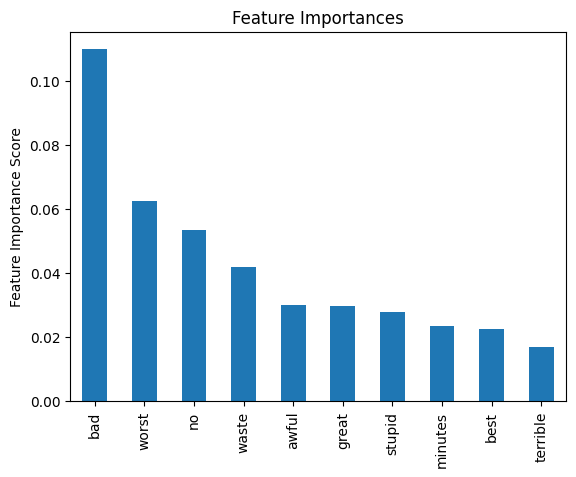

In [25]:
from sklearn.ensemble import GradientBoostingClassifier  # GBM algorithm
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score, GridSearchCV

def modelfit(alg, train_x, train_y, predictors, test_x, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train_x, train_y)
        
    #Predict training set:
    predictions = alg.predict(train_x)
    predprob = alg.predict_proba(train_x)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_y,predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    import matplotlib.pyplot as plt
    
    if printFeatureImportance:
        fig,ax = plt.subplots()
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp[:10].plot(kind='bar', title='Feature Importances',ax=ax)
        plt.ylabel('Feature Importance Score')
        
        fig.savefig('GBMimportances.eps', format='eps',bbox_inches='tight')
        fig.savefig('GBMimportances.pdf', format='pdf',bbox_inches='tight')
        fig.savefig('GBMimportances.png', format='png',bbox_inches='tight')
        fig.savefig('GBMimportances.svg', format='svg',bbox_inches='tight')
        
    return alg.predict(test_x)
        
gbm = GradientBoostingClassifier(random_state=10)

start_time = time.time()
test_predictions = modelfit(gbm, train_x, train_y, predictors, test_x)
end_time = time.time()
print("Training the Gradient Boosting Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = test_predictions
print("DEBUG::The Gradient Boosting predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)

print("DEBUG::The Gradient Boosting testing accuracy score is::")
print(acc_score)

**Make figures downloadable to local system in interactive mode**

In [26]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='GBMimportances.svg')

In [27]:
# you must remove all downloaded files - having too many of them on completion will make Kaggle reject your notebook 
!rm -rf aclImdb
!rm aclImdb_v1.tar.gz

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
